# When Do Crimes Happen in NYC?

I was inspired by Ben Wellington's post on I Quant NY: http://iquantny.tumblr.com/post/142278062424/in-nyc-more-robberies-happen-right-when-school

I thought it would be fun to see if I could re-create his analysis on crime rates in NYC.

Here is the data set from NYC OpenData: https://data.cityofnewyork.us/Public-Safety/NYPD-7-Major-Felony-Incidents/hyij-8hr7

In [311]:
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
%matplotlib inline

## Raw Data

In [4]:
url = 'https://data.cityofnewyork.us/api/views/hyij-8hr7/rows.csv?accessType=DOWNLOAD'

In [5]:
raw_data = pd.read_csv(url)

In [6]:
raw_data.head()

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Offense Classification,Sector,Precinct,Borough,Jurisdiction,XCoordinate,YCoordinate,Location 1
0,1,f070032d,09/06/1940 07:30:00 PM,Friday,Sep,6,1940,19,9,7,2010,BURGLARY,FELONY,D,66,BROOKLYN,N.Y. POLICE DEPT,987478,166141,"(40.6227027620001, -73.9883732929999)"
1,2,c6245d4d,12/14/1968 12:20:00 AM,Saturday,Dec,14,1968,0,12,14,2008,GRAND LARCENY,FELONY,G,28,MANHATTAN,N.Y. POLICE DEPT,996470,232106,"(40.8037530600001, -73.955861904)"
2,3,716dbc6f,10/30/1970 03:30:00 PM,Friday,Oct,30,1970,15,10,31,2008,BURGLARY,FELONY,H,84,BROOKLYN,N.Y. POLICE DEPT,986508,190249,"(40.688874254, -73.9918594329999)"
3,4,638cd7b7,07/18/1972 11:00:00 PM,Tuesday,Jul,18,1972,23,7,19,2012,GRAND LARCENY OF MOTOR VEHICLE,FELONY,F,73,BROOKLYN,N.Y. POLICE DEPT,1005876,182440,"(40.6674141890001, -73.9220463899999)"
4,5,6e410287,05/21/1987 12:01:00 AM,Thursday,May,21,1987,0,5,28,2009,GRAND LARCENY,FELONY,K,75,BROOKLYN,N.Y. POLICE DEPT,1017958,182266,"(40.6668988440001, -73.878495425)"


In [7]:
raw_data.dtypes

OBJECTID                  float64
Identifier                 object
Occurrence Date            object
Day of Week                object
Occurrence Month           object
Occurrence Day            float64
Occurrence Year           float64
Occurrence Hour           float64
CompStat Month            float64
CompStat Day              float64
CompStat Year             float64
Offense                    object
Offense Classification     object
Sector                     object
Precinct                  float64
Borough                    object
Jurisdiction               object
XCoordinate               float64
YCoordinate               float64
Location 1                 object
dtype: object

## Clean the data

Select years 2006 through 2015 into new dataframe.

In [8]:
df = raw_data[(raw_data['Occurrence Year'] >= 2006) & (raw_data['Occurrence Year'] <= 2015)].copy()

Convert columns in dataframe to the appropriate types.

In [9]:
# Convert floats to integers
df['OBJECTID'] = df['OBJECTID'].fillna(0).astype(int)
df['Occurrence Day'] = df['Occurrence Day'].fillna(0).astype(int)
df['Occurrence Year'] = df['Occurrence Year'].fillna(0).astype(int)
df['Occurrence Hour'] = df['Occurrence Hour'].fillna(0).astype(int)
df['CompStat Month'] = df['CompStat Month'].fillna(0).astype(int)
df['CompStat Day'] = df['CompStat Day'].fillna(0).astype(int)
df['CompStat Year'] = df['CompStat Year'].fillna(0).astype(int)
df['Precinct'] = df['Precinct'].fillna(0).astype(int)

# Convert categorical columns to categories
df['Offense'] = df['Offense'].astype('category')
df['Offense Classification'] = df['Offense Classification'].astype('category')
df['Sector'] = df['Sector'].astype('category')
df['Precinct'] = df['Precinct'].astype('category')
df['Borough'] = df['Borough'].astype('category')

# Convert Occurence Date column to datetime
df['Occurrence Date'] = pd.to_datetime(df['Occurrence Date'])

In [10]:
df.dtypes

OBJECTID                           int32
Identifier                        object
Occurrence Date           datetime64[ns]
Day of Week                       object
Occurrence Month                  object
Occurrence Day                     int32
Occurrence Year                    int32
Occurrence Hour                    int32
CompStat Month                     int32
CompStat Day                       int32
CompStat Year                      int32
Offense                         category
Offense Classification          category
Sector                          category
Precinct                        category
Borough                         category
Jurisdiction                      object
XCoordinate                      float64
YCoordinate                      float64
Location 1                        object
dtype: object

In [11]:
# Sort by Occurrence Date
df.sort('Occurrence Date', inplace=True)

In [12]:
# Reset index
df.reset_index(drop=True, inplace=True)

In [13]:
df.head()

,OBJECTID,Identifier,Occurrence Date,Day of Week,Occurrence Month,Occurrence Day,Occurrence Year,Occurrence Hour,CompStat Month,CompStat Day,CompStat Year,Offense,Offense Classification,Sector,Precinct,Borough,Jurisdiction,XCoordinate,YCoordinate,Location 1
0,13959,e99a726,1900-03-10 19:00:00,Saturday,Mar,10,2006,19,3,20,2006,BURGLARY,FELONY,K,66,BROOKLYN,N.Y. POLICE DEPT,991680,174677,"(40.646129746, -73.973227133)"
1,17531,46381a23,1900-08-07 08:30:00,Tuesday,Aug,7,2006,8,8,7,2006,BURGLARY,FELONY,H,61,BROOKLYN,N.Y. POLICE DEPT,1000205,159291,"(40.6038871490001, -73.9425433179999)"
2,14964,4859bb2a,2006-01-01 00:00:00,Sunday,Jan,1,2006,0,8,17,2012,RAPE,FELONY,K,75,BROOKLYN,N.Y. POLICE DEPT,1017141,183798,"(40.671106911, -73.881432957)"
3,14963,5369a768,2006-01-01 00:00:00,Sunday,Jan,1,2006,0,5,8,2007,GRAND LARCENY,FELONY,D,62,BROOKLYN,N.Y. POLICE DEPT,982486,158625,"(40.602073299, -74.0063538919999)"
4,14965,c452741f,2006-01-01 00:00:00,Sunday,Jan,1,2006,0,1,10,2008,GRAND LARCENY,FELONY,I,79,BROOKLYN,N.Y. POLICE DEPT,997284,190005,"(40.688195222, -73.9530032609999)"


## What times of day do major felonies happen?

In [14]:
# The groupby method can be used to slice and dice data frames
g = df.groupby(df['Offense'])

In [15]:
g.describe()

CompStat Day  CompStat Month  \
Offense                                                               
BURGLARY                       count  191045.000000   191045.000000   
                               mean       15.863723        6.732283   
                               std         8.800714        3.433935   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        16.000000        7.000000   
                               75%        23.000000       10.000000   
                               max        31.000000       12.000000   
FELONY ASSAULT                 count  183879.000000   183879.000000   
                               mean       15.709673        6.619696   
                               std         8.862548        3.296956   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        16.000000        7.000000   
                               75%        23.000000        9.000000   
                               max        31.000000       12.000000   
GRAND LARCENY                  count  424635.000000   424635.000000   
                               mean       15.758955        6.754274   
                               std         8.759363        3.408620   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        16.000000        7.000000   
                               75%        23.000000       10.000000   
                               max        31.000000       12.000000   
GRAND LARCENY OF MOTOR VEHICLE count  101728.000000   101728.000000   
                               mean       15.868758        6.709244   
                               std         8.776883        3.378726   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        16.000000        7.000000   
                               75%        23.000000       10.000000   
                               max        31.000000       12.000000   
MURDER & NON-NEGL. MANSLAUGHTE count    4443.000000     4443.000000   
                               mean       15.824893        6.697277   
                               std         8.929432        3.320215   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        16.000000        7.000000   
                               75%        24.000000        9.000000   
                               max        31.000000       12.000000   
RAPE                           count   12974.000000    12974.000000   
                               mean       15.530985        6.580931   
                               std         8.842302        3.381867   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        15.000000        7.000000   
                               75%        23.000000        9.000000   
                               max        31.000000       12.000000   
ROBBERY                        count  198569.000000   198569.000000   
                               mean       15.891670        6.779402   
                               std         8.804378        3.440681   
                               min         1.000000        1.000000   
                               25%         8.000000        4.000000   
                               50%        16.000000        7.000000   
                               75%        23.000000       10.00

In [16]:
# Calculate total row counts grouped by Offense type
df['Occurrence Date'].groupby(df['Offense']).count()

Offense
BURGLARY                          191045
FELONY ASSAULT                    183879
GRAND LARCENY                     424635
GRAND LARCENY OF MOTOR VEHICLE    101728
MURDER & NON-NEGL. MANSLAUGHTE      4443
RAPE                               12974
ROBBERY                           198569
Name: Occurrence Date, dtype: int64

In [17]:
# Calulate row counts grouped by Occurrence Hour and Offense
offense_by_hour = df['Occurrence Date'].groupby([df['Occurrence Hour'], df['Offense']]).count().unstack()
offense_by_hour.head()

Offense,BURGLARY,FELONY ASSAULT,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,MURDER & NON-NEGL. MANSLAUGHTE,RAPE,ROBBERY
Occurrence Hour,,,,,,,
0,5575,10161,23173,4456,281,1641,10065
1,4629,9565,10686,3762,258,650,9833
2,4405,9065,8980,2744,257,721,8740
3,4021,8794,7598,2030,246,665,8199
4,3995,8289,5568,1743,266,612,8014


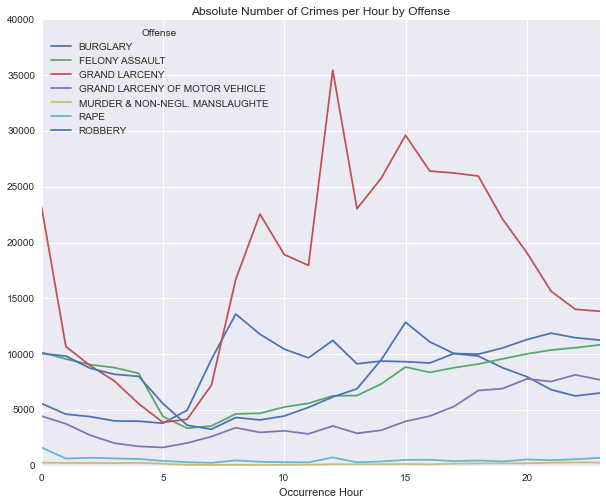

In [18]:
# Plot row counts grouped by Occurrence Hour and Offense
offense_by_hour.plot(figsize=(10,8), title='Absolute Number of Crimes per Hour by Offense')

Nice! We're getting somewhere. The chart above shows the total absolute count of incidents by offense type. We're looking for the hourly crime rate, though. So, we need to divide the absolute incident counts by the number of days in our period.

In [19]:
# Calculate days in 2006-2015
first_day = df['Occurrence Date'][2]
last_day = df['Occurrence Date'].max()
delta = last_day - first_day
days = delta.days-1
print "# of days in time period:", days

# of days in time period: 3650


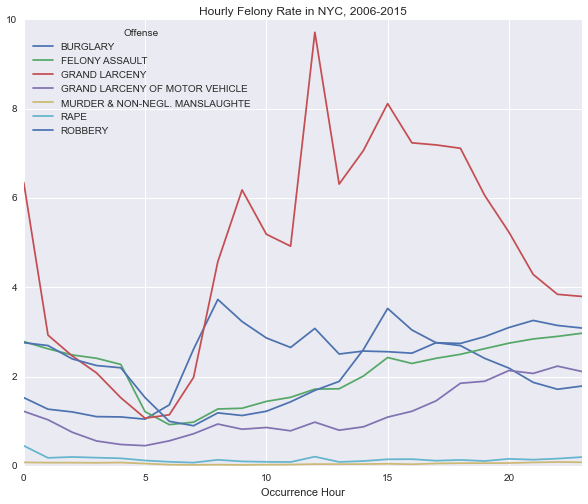

In [20]:
# Convert absoulute number of crimes per hour into hourly crime rate by dividing by number of days
crime_rate_hourly_by_offense = offense_by_hour.div(days)
crime_rate_hourly_by_offense.plot(figsize=(10,8), title='Hourly Felony Rate in NYC, 2006-2015');

Is school getting out responsible for more crimes? Let's look into further by comparing crime rates on school days versus non-school days.

## Do crime rates increase when school gets out?

I want to categorize every day as either 1. School Day, 2. Weekday Holiday, 3. Weekend or 4. Summer Vacation.

In order to do so I'll need to insert a Date column into the dataframe that is simply a date (rather than a datetime stamp)

In [21]:
# Set datetime to simply date value (we may need this later)
df['Date'] = df['Occurrence Date'].dt.date

In [22]:
# Create Month-Day column to store a (Month, Day) tuple in order to compare month-days
df['Month-Day'] = zip([date.date().month for date in df['Occurrence Date']],df['Occurrence Day'])

In [23]:
# I made a CSV of school year holidays in 2015-2016 per http://schools.nyc.gov/Calendar/default.htm
holidays = pd.read_csv('C:/Users/Will/Desktop/2015_holidays.csv')
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays['Month'] = [date.date().month for date in holidays['Date']]
holidays['Day'] = [date.date().day for date in holidays['Date']]
holidays['Month-Day'] = zip(holidays.Month, holidays.Day)
holidays.head()

,Date,Holiday,Month,Day,Month-Day
0,2015-09-14,Rosh Hashanah,9,14,"(9, 14)"
1,2015-09-15,Rosh Hashanah,9,15,"(9, 15)"
2,2015-09-23,Yom Kippur,9,23,"(9, 23)"
3,2015-09-24,Eid al-Adha,9,24,"(9, 24)"
4,2015-10-12,Columbus Day,10,12,"(10, 12)"


In [24]:
# Set summer vacation = 1 where month is July, August or September (and before Sept 9)
df['Summer Vacation'] = np.where((df['Occurrence Month'] == 'Jul') | (df['Occurrence Month'] =='Aug')
                                 | ((df['Occurrence Month'] == 'Sep') & (df['Occurrence Day'] < 9)),1,0)

# Set weekend day = 1 where day is Saturday or Sunday
df['Weekend Day'] = np.where(((df['Day of Week'] == 'Saturday') | (df['Day of Week'] == 'Sunday')),1,0)

# Set weekday holiday = 1 if the month-day was a holiday in 2015. This assumes month-day holidays will be same in other years
df['Weekday Holiday'] = [1 if monthday in list(holidays['Month-Day']) else 0 for monthday in df['Month-Day']]

# Set school day = 1 if none of the previous three new columns are = 1
df['School Day'] = np.where((df['Summer Vacation'] != 1) & (df['Weekend Day'] != 1) & (df['Weekday Holiday'] !=1),1,0)

In [25]:
# Set Day Type equal to which ever of the previous for new columns has a 1
def day_type(row):
    if row['Summer Vacation'] == 1:
        return 'Summer Vacation'
    if row['Weekend Day'] == 1:
        return 'Weekend Day'
    if row['Weekday Holiday'] == 1:
        return 'Weekday Holiday'
    if row['School Day'] == 1:
        return 'School Day'

df['Day Type'] = df.apply(lambda row: day_type(row), axis=1)

In [26]:
# Convert Day Type column to categorical
df['Day Type'] = df['Day Type'].astype('category')

In [27]:
# Don't need this anymore - but keeping this to refer back to later
first_day = datetime.date(pd.to_datetime('9/9/2015')) # First day of school in 2015-2016 year
last_day = datetime.date(pd.to_datetime('6/28/2016')) # Last day of school in 2015-2016 year

In [28]:
df.dtypes

OBJECTID                           int32
Identifier                        object
Occurrence Date           datetime64[ns]
Day of Week                       object
Occurrence Month                  object
Occurrence Day                     int32
Occurrence Year                    int32
Occurrence Hour                    int32
CompStat Month                     int32
CompStat Day                       int32
CompStat Year                      int32
Offense                         category
Offense Classification          category
Sector                          category
Precinct                        category
Borough                         category
Jurisdiction                      object
XCoordinate                      float64
YCoordinate                      float64
Location 1                        object
Date                              object
Month-Day                         object
Summer Vacation                    int32
Weekend Day                        int32
Weekday Holiday 

In [29]:
len(np.unique(df[df['Day Type'] == 'School Day']['Month-Day']))

258

In [30]:
crimes_by_day_type = df['Occurrence Date'].groupby([df['Occurrence Hour'], df['Day Type']]).count().unstack()
crime_rate_hourly_by_day_type = crimes_by_day_type.div(days)

crime_rate_hourly_by_day_type.head()

Day Type,School Day,Summer Vacation,Weekday Holiday,Weekend Day
Occurrence Hour,,,,
0,6.735616,3.466301,1.072877,3.890137
1,4.010685,2.609589,0.659178,3.510411
2,3.286027,2.338904,0.598630,3.341370
3,2.790685,2.060274,0.506301,3.287397
4,2.482740,1.913151,0.450137,2.958630


<IPython.core.display.Javascript object>


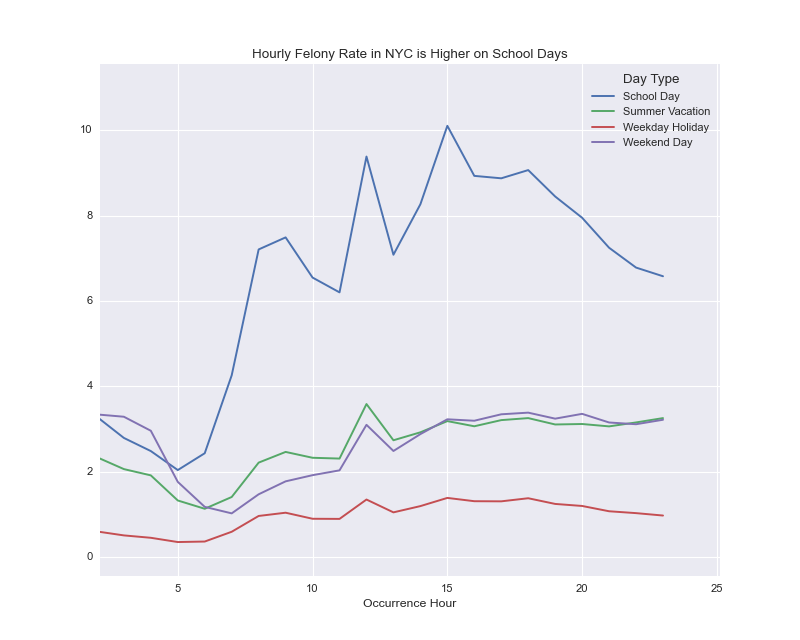

In [126]:
crime_rate_hourly_by_day_type.plot(figsize=(10,8), title='Hourly Felony Rate in NYC is Higher on School Days');

## Robberies

Let's look into robberies, specifically.

In [32]:
robbery = df[df['Offense'] == 'ROBBERY']

robbery_by_day_type = robbery['Occurrence Date'].groupby([robbery['Occurrence Hour'], robbery['Day Type']]).count().unstack()
robbery_rate_hourly_by_day_type = robbery_by_day_type.div(days)

robbery_rate_hourly_by_day_type.head()

Day Type,School Day,Summer Vacation,Weekday Holiday,Weekend Day
Occurrence Hour,,,,
0,1.169863,0.674521,0.192055,0.721096
1,1.047945,0.710685,0.162192,0.773151
2,0.876986,0.628219,0.154247,0.735068
3,0.752603,0.603014,0.131233,0.759452
4,0.687671,0.595342,0.123562,0.789041


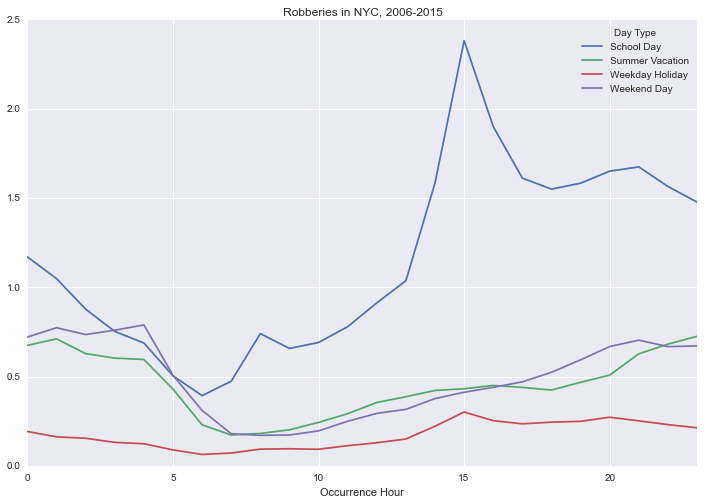

In [33]:
robbery_rate_hourly_by_day_type.plot(figsize=(12,8), title='Robberies in NYC, 2006-2015');

Robberies see a spike when school gets out.

## Burglaries

Now let's look into burglaries.

In [34]:
burglary = df[df['Offense'] == 'BURGLARY']

burglary_by_day_type = burglary['Occurrence Date'].groupby([burglary['Occurrence Hour'], burglary['Day Type']]).count().unstack()
burglary_rate_hourly_by_day_type = burglary_by_day_type.div(days)

burglary_rate_hourly_by_day_type.head()

Day Type,School Day,Summer Vacation,Weekday Holiday,Weekend Day
Occurrence Hour,,,,
0,0.690137,0.365753,0.106849,0.364658
1,0.571233,0.300822,0.078082,0.318082
2,0.561370,0.292329,0.081644,0.271507
3,0.498630,0.270137,0.081644,0.251233
4,0.491233,0.254795,0.075616,0.272877


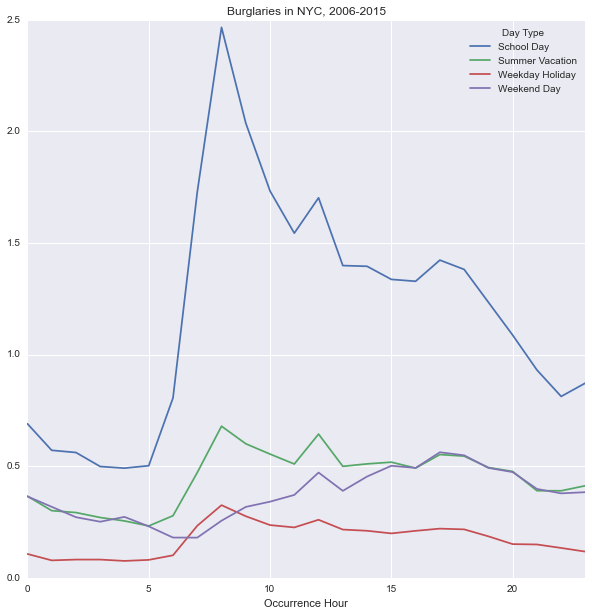

In [35]:
burglary_rate_hourly_by_day_type.plot(figsize=(10,10), title='Burglaries in NYC, 2006-2015');

Burglaries, on the other hand, see a morning spike on school days.

## Felony Assault

In [36]:
felonyassault = df[df['Offense'] == 'FELONY ASSAULT']

felonyassault_by_day_type = felonyassault['Occurrence Date'].groupby([felonyassault['Occurrence Hour'],
                                                                      felonyassault['Day Type']]).count().unstack()
felonyassault_rate_hourly_by_day_type = felonyassault_by_day_type.div(days)

felonyassault_rate_hourly_by_day_type.head()

Day Type,School Day,Summer Vacation,Weekday Holiday,Weekend Day
Occurrence Hour,,,,
0,1.014247,0.704384,0.155616,0.909589
1,0.830959,0.672329,0.144110,0.973151
2,0.668219,0.595068,0.148219,1.072055
3,0.611233,0.536712,0.129315,1.132055
4,0.554247,0.522466,0.124110,1.070137


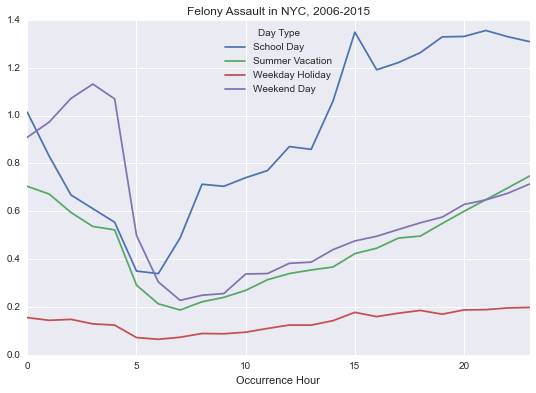

In [37]:
felonyassault_rate_hourly_by_day_type.plot(figsize=(9,6), title='Felony Assault in NYC, 2006-2015');

Felony assault jumps up latenight on weekend nights and then back up again on school days.

## Grand Larceny

In [38]:
grandlarceny = df[df['Offense'] == 'GRAND LARCENY']

grandlarceny_by_day_type = grandlarceny['Occurrence Date'].groupby([grandlarceny['Occurrence Hour'],
                                                                    grandlarceny['Day Type']]).count().unstack()
grandlarceny_rate_hourly_by_day_type = grandlarceny_by_day_type.div(days)

grandlarceny_rate_hourly_by_day_type.head()

Day Type,School Day,Summer Vacation,Weekday Holiday,Weekend Day
Occurrence Hour,,,,
0,3.109041,1.311781,0.483836,1.444110
1,1.055616,0.615068,0.192055,1.064932
2,0.794795,0.564384,0.152329,0.948767
3,0.643836,0.453151,0.115068,0.869589
4,0.497534,0.367945,0.086849,0.573151


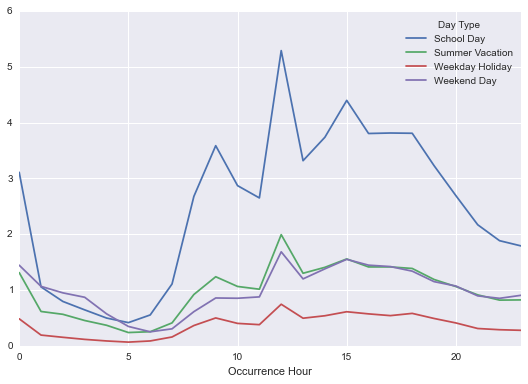

In [39]:
grandlarceny_rate_hourly_by_day_type.plot(figsize=(9,6));

Spikes across all crimes when kids leave school.

## Grand Larceny of Motor Vehicles

In [40]:
grandlarcenymv = df[df['Offense'] == 'GRAND LARCENY OF MOTOR VEHICLE']

grandlarcenymv_by_day_type = grandlarcenymv['Occurrence Date'].groupby([grandlarcenymv['Occurrence Hour'],
                                                                        grandlarcenymv['Day Type']]).count().unstack()
grandlarcenymv_rate_hourly_by_day_type = grandlarcenymv_by_day_type.div(days)

grandlarcenymv_rate_hourly_by_day_type.head()

Day Type,School Day,Summer Vacation,Weekday Holiday,Weekend Day
Occurrence Hour,,,,
0,0.537260,0.292877,0.078904,0.311781
1,0.420000,0.247123,0.064658,0.298904
2,0.294521,0.187123,0.044932,0.225205
3,0.204110,0.136986,0.036986,0.178082
4,0.181370,0.114795,0.029863,0.151507


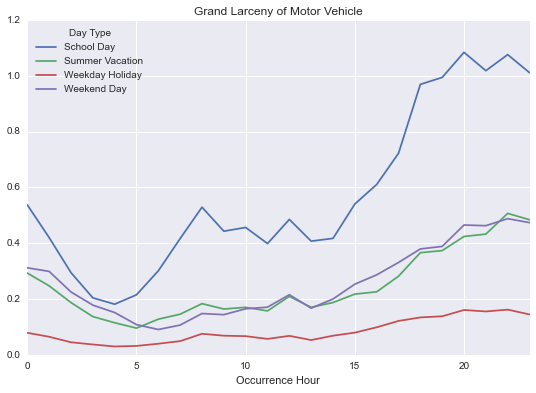

In [41]:
grandlarcenymv_rate_hourly_by_day_type.plot(figsize=(9,6), title='Grand Larceny of Motor Vehicle');

Murder and rape have too few instance for this kind of comparison, so skip them.

## Was more crime committed on school days overall, or at different times?

Calculate the number of school days, summer days, weekday holidays and weekend days. The below finds the number of unique days in 2015 for each type of day and then multiplies it by the number of years in our data set (10). 

In [280]:
# Number of years in our data set (from 2006 to 2015)
num_years = df['Occurrence Year'].max() - df['Occurrence Year'].min() + 1

# Number of summer days
summer_days_per_year = len(np.unique(df[(df['Day Type'] == 'Summer Vacation') & (df['Occurrence Year'] == 2015)]['Month-Day']))
summer_days = summer_days_per_year * num_years

# Number of school days
school_days_per_year = len(np.unique(df[(df['Day Type'] == 'School Day') & (df['Occurrence Year'] == 2015)]['Month-Day']))
school_days = school_days_per_year * num_years

# Number of weekday holidays
weekday_holidays_per_year = len(np.unique(df[(df['Day Type'] == 'Weekday Holiday') & (df['Occurrence Year'] == 2015)]['Month-Day']))
weekday_holidays = weekday_holidays_per_year * num_years

# Number of weekend days
weekend_days_per_year = len(np.unique(df[(df['Day Type'] == 'Weekend Day') & (df['Occurrence Year'] == 2015)]['Month-Day']))
weekend_days = weekend_days_per_year * num_years

print '# of Summer Days:', summer_days
print '# of School Days:', school_days
print '# of Weekday Holidays:', weekday_holidays
print '# of Weekend Days:', weekend_days

# of Summer Days: 700
# of School Days: 1780
# of Weekday Holidays: 330
# of Weekend Days: 850


In [217]:
# Define the aggregation calculations
aggregations = {
    'OBJECTID': { # work on the "OBJECT ID" column
        'num_occurrences': 'count',  # get the count, and call this result 'num_occurences'
        'hourly_rate': 'count'} # placeholder for now - we will divide this by number of days next
    }
 
# Perform groupby aggregation by occurrence hour and day type
g = df.groupby([df['Offense'].astype('str'), df['Occurrence Hour'], df['Day Type']]).agg(aggregations).unstack()

# Divide the hourly_rate columns by the appropriate number of days to convert them into hourly rates
g[('OBJECTID', 'hourly_rate', 'School Day')] = g[('OBJECTID', 'hourly_rate', 'School Day')] / school_days
g[('OBJECTID', 'hourly_rate', 'Summer Vacation')] = g[('OBJECTID', 'hourly_rate', 'Summer Vacation')] / summer_days
g[('OBJECTID', 'hourly_rate', 'Weekday Holiday')] = g[('OBJECTID', 'hourly_rate', 'Weekday Holiday')] / weekday_holidays
g[('OBJECTID', 'hourly_rate', 'Weekend Day')] = g[('OBJECTID', 'hourly_rate', 'Weekend Day')] / weekend_days
g.head()

OBJECTID                                  \
                         num_occurrences                                   
Day Type                      School Day Summer Vacation Weekday Holiday   
Offense  Occurrence Hour                                                   
BURGLARY 0                          2519            1335             390   
         1                          2085            1098             285   
         2                          2049            1067             298   
         3                          1820             986             298   
         4                          1793             930             276   

                                                                  \
                                     hourly_rate                   
Day Type                 Weekend Day  School Day Summer Vacation   
Offense  Occurrence Hour                                           
BURGLARY 0                      1331    1.415169        1.907143   
         1                      1161    1.171348        1.568571   
         2                       991    1.151124        1.524286   
         3                       917    1.022472        1.408571   
         4                       996    1.007303        1.328571   

                                                      
                                                      
Day Type                 Weekday Holiday Weekend Day  
Offense  Occurrence Hour                              
BURGLARY 0                      1.181818    1.565882  
         1                      0.863636    1.365882  
         2                      0.903030    1.165882  
         3                      0.903030    1.078824  
         4                      0.836364    1.171765

In [277]:
for x in np.unique(g.index.get_level_values(0)):
    print x

BURGLARY
FELONY ASSAULT
GRAND LARCENY
GRAND LARCENY OF MOTOR VEHICLE
MURDER & NON-NEGL. MANSLAUGHTE
RAPE
ROBBERY


Make a plot for each type of offense.

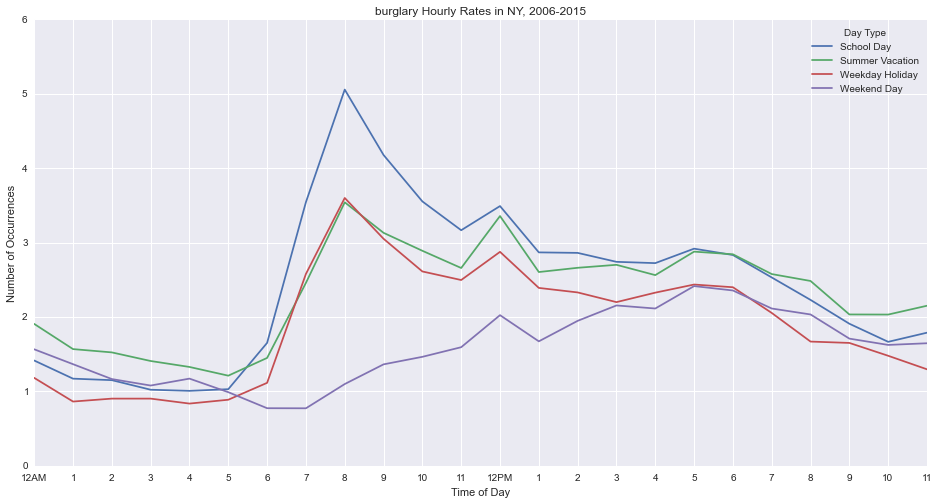

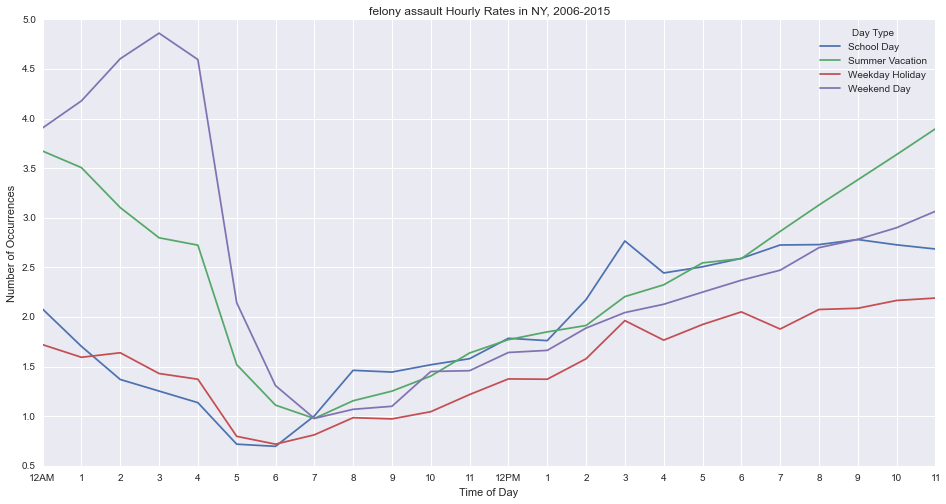

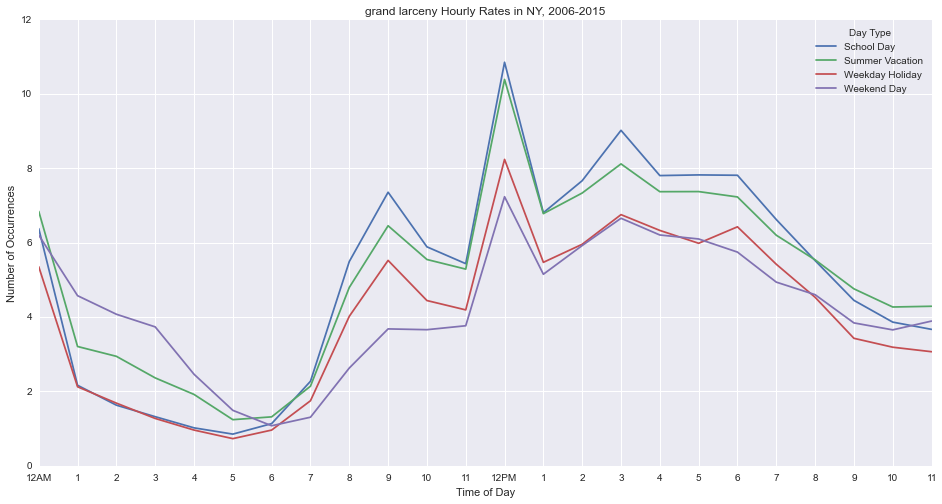

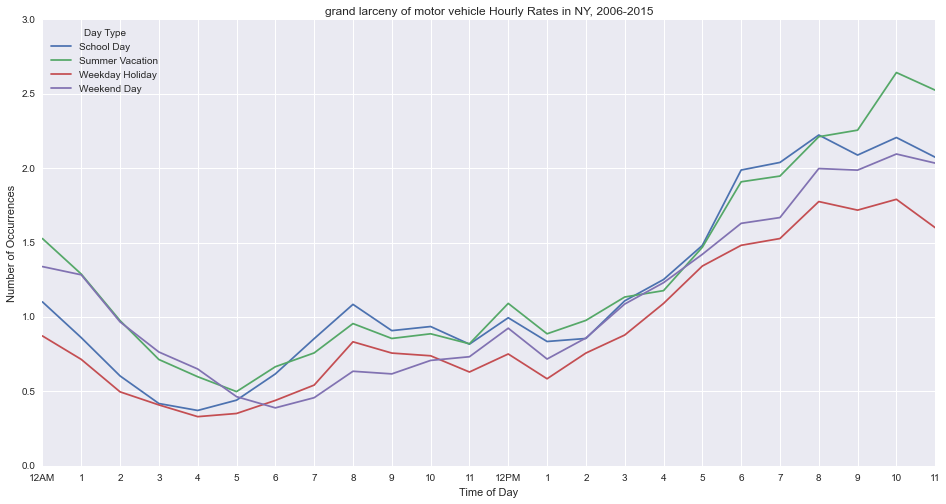

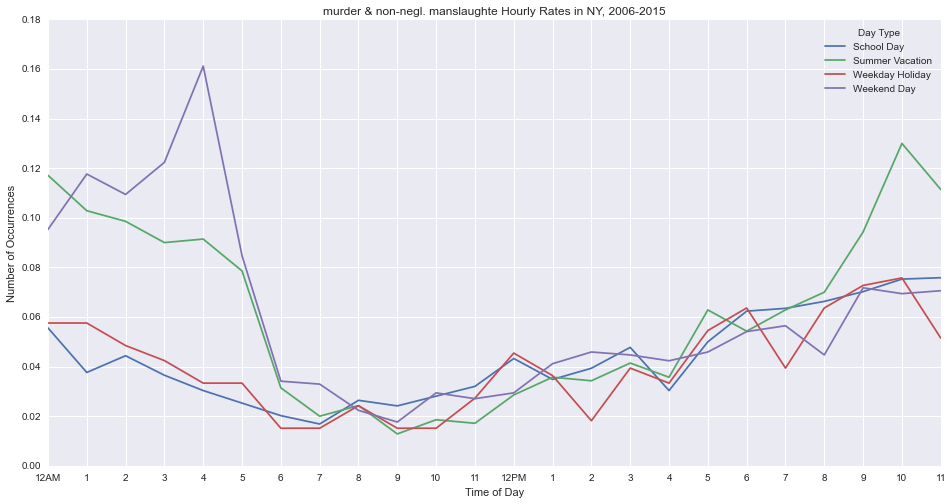

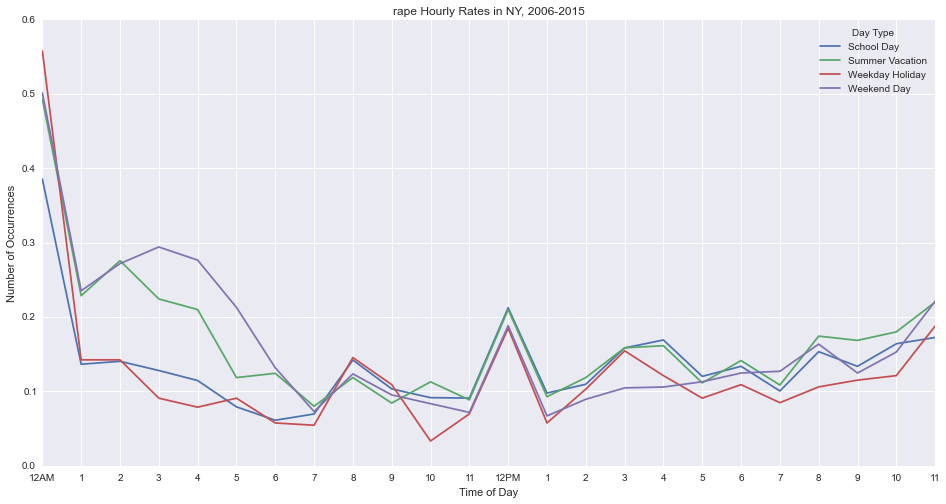

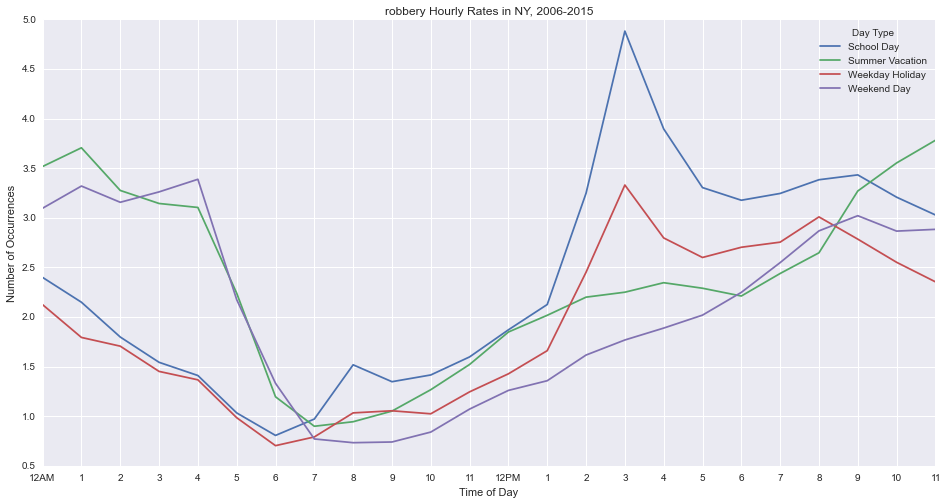

In [306]:
for x in np.unique(g.index.get_level_values(0)):
    ax = plt.figure()
    g.loc[x,('OBJECTID', 'hourly_rate')].plot(figsize=(16,8), title=x.lower() + ' Hourly Rates in NY, 2006-2015')
    hours = ['12AM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12PM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    plt.xticks(range(len(hours)), hours)
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Time of Day')

In [290]:
#for x in np.unique(g.index.get_level_values(0)):
#    g.loc[x,('OBJECTID', 'hourly_rate')].plot(figsize=(16,8), title=x.lower() + ' Hourly Rates in NY, 2006-2015')


<IPython.core.display.Javascript object>


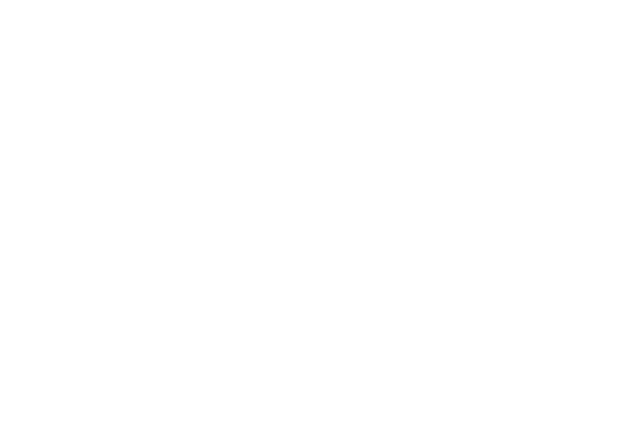

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [267]:
#fig, ax = plt.subplots(nrows=2)

fig, ax = plt.subplots(nrows=7)
months = ['12AM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12PM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
for x in np.unique(g.index.get_level_values(0)):
    ax.plot(g.loc[x, ('OBJECTID', 'hourly_rate')])
    ax.set_title(x + " in NYC 2006-2015")
    ax.set_xlim(0,23)
    ax.set_ylabel('Hourly Crime Rate')
    plt.setp(ax,xticks=range(len(months)), xticklabels=months)

fig.tight_layout();

#ax[0].plot(g.loc['ROBBERY',('OBJECTID', 'hourly_rate')], label='Robbery')
#ax[0].set_title('Robberies in NYC 2006-2015')
#ax[0].set_xlim(0,23)
#ax[0].set_ylabel('Hourly Crime Rate')

# Add hours as x-axis ticks
#months = ['12AM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, '12PM', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
#plt.setp(ax,xticks=range(len(months)), xticklabels=months)

## Daily Felony Rate 2006-2015

In [175]:
# Define the aggregation calculations
aggregations = {
    'OBJECTID': { # work on the "OBJECT ID" column
        'num_occurrences': 'count'}  # get the count, and call this result 'num_occurences'
    }
 
# Perform groupby aggregation by occurrence hour and day type
c = df.groupby([df['Offense'].astype('str'), df['Day Type']]).agg(aggregations).unstack()

# Divide the num_occurrences columns by the appropriate number of days to convert them into daily rates
c[('OBJECTID', 'num_occurrences', 'School Day')] = c[('OBJECTID', 'num_occurrences', 'School Day')] / school_days
c[('OBJECTID', 'num_occurrences', 'Summer Vacation')] = c[('OBJECTID', 'num_occurrences', 'Summer Vacation')] / summer_days
c[('OBJECTID', 'num_occurrences', 'Weekday Holiday')] = c[('OBJECTID', 'num_occurrences', 'Weekday Holiday')] / weekday_holidays
c[('OBJECTID', 'num_occurrences', 'Weekend Day')] = c[('OBJECTID', 'num_occurrences', 'Weekend Day')] / weekend_days
c

OBJECTID                  \
                               num_occurrences                   
Day Type                            School Day Summer Vacation   
Offense                                                          
BURGLARY                             58.512360       55.967143   
FELONY ASSAULT                       45.645506       56.971429   
GRAND LARCENY                       122.810674      123.677143   
GRAND LARCENY OF MOTOR VEHICLE       28.161236       30.771429   
MURDER & NON-NEGL. MANSLAUGHTE        1.036517        1.464286   
RAPE                                  3.268539        4.004286   
ROBBERY                              56.791573       56.718571   

                                                            
                                                            
Day Type                       Weekday Holiday Weekend Day  
Offense                                                     
BURGLARY                             46.142424   38.222353  
FELONY ASSAULT                       36.739394   59.560000  
GRAND LARCENY                        97.781818  102.576471  
GRAND LARCENY OF MOTOR VEHICLE       22.418182   26.662353  
MURDER & NON-NEGL. MANSLAUGHTE        0.978788    1.470588  
RAPE                                  3.009091    3.952941  
ROBBERY                              45.703030   50.229412

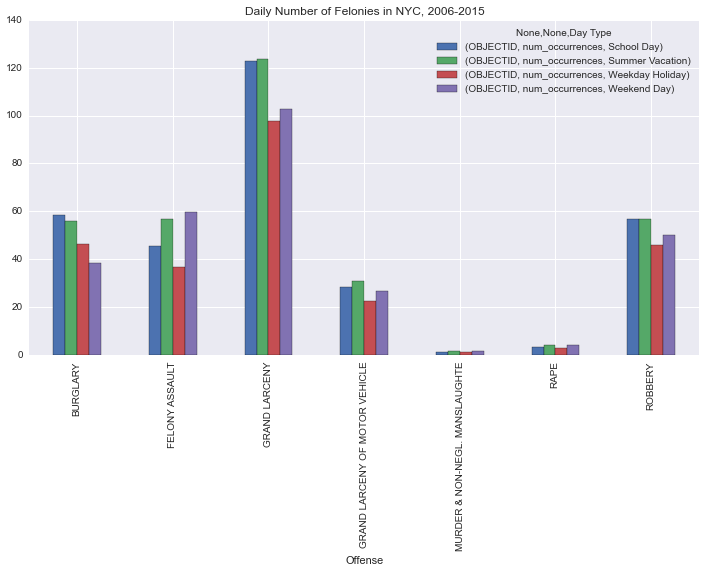

In [312]:
c.plot(kind='bar', figsize=(12,6), title='Daily Number of Felonies in NYC, 2006-2015');

## How have crime rates changed over time?

In [210]:
# Define the aggregation calculations
aggregations = {
    'OBJECTID': { # work on the "OBJECT ID" column
        'num_occurrences': 'count',  # get the count, and call this result 'num_occurences'
        'hourly_rate': 'count'} # placeholder for now - we will divide this by number of days next
    }
 
# Perform groupby aggregation by occurrence hour and day type
g = df.groupby([df['Offense'], df['Occurrence Hour'], df['Occurrence Year'].astype('str')]).agg(aggregations).unstack()

# Divide houry_rate columns by days
g[('OBJECTID', 'hourly_rate')] = g[('OBJECTID', 'hourly_rate')] / (days/10)
g.head()

OBJECTID                                     \
                         num_occurrences                                      
Occurrence Year                     2006 2007 2008 2009 2010 2011 2012 2013   
Offense  Occurrence Hour                                                      
BURGLARY 0                           672  589  636  496  578  506  568  516   
         1                           533  514  467  421  437  439  489  461   
         2                           476  459  451  388  413  412  463  446   
         3                           470  379  379  348  400  432  413  382   
         4                           449  396  394  342  394  360  487  368   

                                                                              \
                                   hourly_rate                                 
Occurrence Year          2014 2015        2006      2007      2008      2009   
Offense  Occurrence Hour                                                       
BURGLARY 0                518  496    1.841096  1.613699  1.742466  1.358904   
         1                435  433    1.460274  1.408219  1.279452  1.153425   
         2                432  465    1.304110  1.257534  1.235616  1.063014   
         3                384  434    1.287671  1.038356  1.038356  0.953425   
         4                385  420    1.230137  1.084932  1.079452  0.936986   

                                                                            \
                                                                             
Occurrence Year               2010      2011      2012      2013      2014   
Offense  Occurrence Hour                                                     
BURGLARY 0                1.583562  1.386301  1.556164  1.413699  1.419178   
         1                1.197260  1.202740  1.339726  1.263014  1.191781   
         2                1.131507  1.128767  1.268493  1.221918  1.183562   
         3                1.095890  1.183562  1.131507  1.046575  1.052055   
         4                1.079452  0.986301  1.334247  1.008219  1.054795   

                                    
                                    
Occurrence Year               2015  
Offense  Occurrence Hour            
BURGLARY 0                1.358904  
         1                1.186301  
         2                1.273973  
         3                1.189041  
         4                1.150685

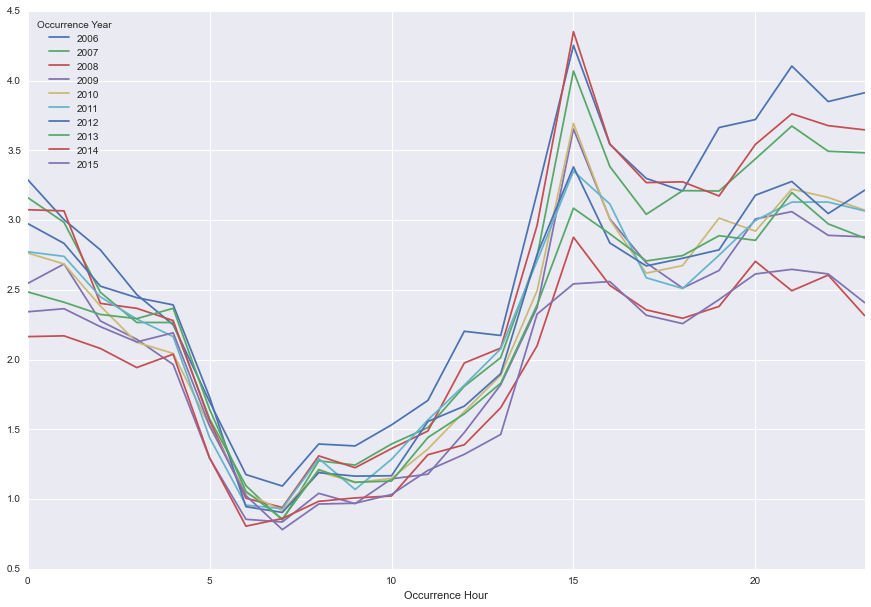

In [216]:
g.loc['ROBBERY',('OBJECTID', 'hourly_rate')].plot(figsize=(15,10), title='');